# CodeLab4 - Feature Extraction
Feature engineering is the art and science of selecting, transforming, and creating meaningful input features from raw data. Machine learning algorithms can extract valuable patterns and make accurate predictions. This exercise focuses on biomedical images derived from three distinct modalities: chest X-rays, abdomen and head CT scans. 

Feature extraction tasks heavily rely on the type of data and the objective. For instance, object detection tasks rely on edge detection, blob detection, and shape descriptors. For more complex tasks, e.g., ML aided diagnosis of pneumonia, convolutional neural networks (CNN) are often employed due to their high performance in image processing. The multi-layer structure remains identical as in neural network, with the main difference being in the learned parameters, which are the kernel weights, as opposed to the neuron weights. Kernels are small windows (filters), which overlap to the input image/data. The element wise products between the kernel weights and the overlapping portion of the input image are added together to produce a new feature map. After each summation step, the filter slides to the next region of the image.

In this lab, you will use a set of selected biomedical images to classify and categorize the dataset. Meanwhile, the effect of the feature selection on the image dataset will be discussed. You will also tell the differences before and after feature engineering. Hyperparameter tuning is also an important factor in the training process of modern ML workflow. A grid search method will be deployed to find the optimal model parameters for this specific task. 

Provide your answers in a report in PDF format that contains all the requested outputs and answers to the questions. You will obtain a Pass or Fail from each CodeLab, where a sufficient amount of work and answers are required for each part of the CodeLab. Missing parts and question answers will cause a Fail for the associated CodeLab. You do not have to submit the Jupyter Notebook, but TAs can request it after submission. Using LLM models is not prohibited, but the exact answers to written questions from different students will be regarded as plagiarism and automatic Fail. The report must be submitted to Brightspace before the deadline.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np

np.random.seed(42)
random.seed(42)

## Task A - Dataset preparation 

This cell checks if a directory named "dataset" exists. If it does not exist, it opens the zip file named "dataset.zip" and extracts its contents into the "dataset" directory.

In [3]:
import os
import zipfile

if not os.path.exists("dataset"):
    with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
        zip_ref.extractall("dataset")
else:
    print("Dataset already exists, skipping unzip")

Dataset already exists, skipping unzip


Create the path to the dataset folder by merging the current working directory and the folder name.
The variable `data_dir` that stores the path to a directory called `dataset\\` within the current working directory.

>**NOTE**: to run this cell in Vocareum/Google Colab/MacOS/Linux the directory name is `dataset/`, if you run it locally on Windows systems use `dataset\\`

In [4]:
data_dir = os.path.join(os.getcwd(), 'dataset/')
print('Number of images in the dataset folder: ', len(os.listdir(data_dir)))

Number of images in the dataset folder:  400


The folder should contain 400 items, if this is not the case, go back to jupyter interface, delete the dataset folder, and retry from the start of the notebook.

- A1) Complete the `load_data` function. It loads the data from the dataset folder. Four different classes are present in the dataset, and labels will be assigned according to their filenames. Make sure all three different formats of images are imported.
The function `fnmatch` is used to search for a specific string in the filenames, labels should be assigned as follows:
        Abdomen CT scans -> Class 0
        Brain CT scans -> Class 1
        Chest X-Rays normal -> Class 2
        Chest X-rays with pneumonia -> Class 3

In [5]:
from fnmatch import fnmatch

def load_data(directory):
    images = []
    labels = []
    for filename in os.listdir(directory): ## iterate over each file in directory
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"): ## check if it is an image
            img = mpimg.imread(os.path.join(directory, filename)) ## read image
            images.append(img)        

        ## assign labels based on filename    
        if fnmatch(filename , "Abdomen*"):
            labels.append(0)
        elif fnmatch(filename, "Brain*"):
            labels.append(1)
        elif fnmatch(filename, "Chest normal*"):
            labels.append(2)
        elif fnmatch(filename, "Chest Pneumonia*"):
            labels.append(3)
        else:
            raise ValueError('Unknown class: %s' % (filename))
    
    return images, np.asarray(labels)

- A2) Load the data using the `load_data()` function and verifiy the sizes of the dataset. It should create 400 samples and 400 labels.

In [6]:
print(os.getcwd()) 
raw_images, labels = load_data("dataset")

print(len(raw_images))
print(labels.shape)

c:\Program Files (x86)\Github_related\MachineLearning_EE\codeLab4
400
(400,)


- A3) Plot random images for each class in the same figure and put them in the report.

Hint: you can use the function `random.choice()` to pick from the indexes that correspond to a specific class (`np.where(condition)`)

3
3
2
2


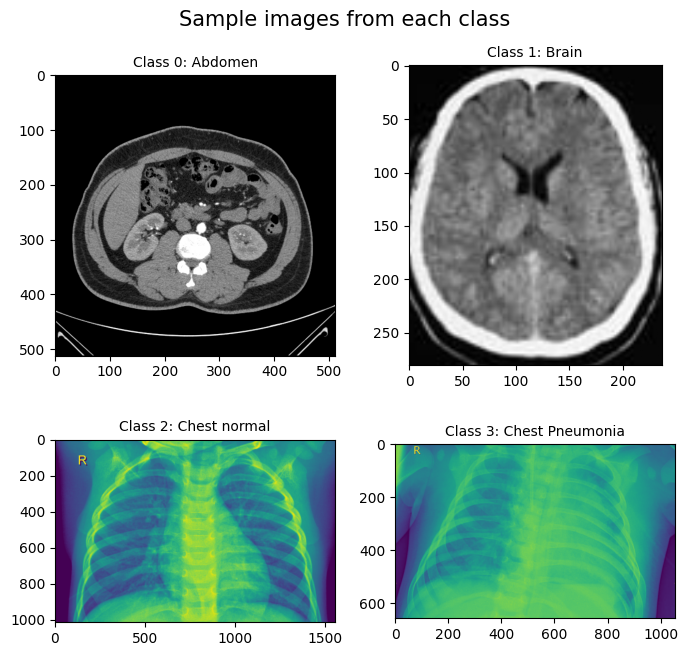

In [7]:
def randomPlot(labels,images,classes):
    plt.figure(figsize=(7,7))
    plt.suptitle('Sample images from each class',fontsize=15)
    for i in range(4):
        j = 0
        temp = []
        while j < len(labels):
            if labels[j] == i:
                temp.append(j)
            j+=1
        idx = random.choice(temp)
        plt.subplot(2,2,i+1)
        plt.title(f"Class {i}: {classes[i]}",fontsize=10)
        print(images[idx].ndim)
        plt.imshow(images[idx])
        # I have no clue why this is inverted ?!?:
        #if images[idx].ndim == 3 or images[idx].ndim == 4:
        #    plt.imshow(images[idx])
        #else:
        #    plt.imshow(images[idx], cmap="grey")
    plt.tight_layout()
    plt.show()


class_names = {0: "Abdomen", 1: "Brain", 2: "Chest normal", 3: "Chest Pneumonia"}
randomPlot(labels,raw_images,class_names)


As you can see, the images have different characteristics: some are RGB, some oethers are B&W, and all have varying shapes. For this reason you're going to resize them and convert them in grayscale.

The `convert_to_grayscale` function takes an image as input and converts it to grayscale using the `cv2.cvtColor` function from the OpenCV library. It uses the `cv2.COLOR_BGR2GRAY` flag to specify the conversion from BGR color space to grayscale. The function then returns the grayscale image.

Only the RGB images need to be converted to grayscale, otherwise cv2 will raise an error, so check for this verifying the shape of each image: RGB images can have 3 or 4 channels, one for each colour + transparency in the case of .png files.

The `resize_images_in_list` function takes a list of images and resizes each image to a specified target size. If the image has 3 or 4 channels (indicating it is a color image), it first converts the image to grayscale using the `convert_to_grayscale` function. Then, it resizes the image using the `cv2.resize` function and appends the resized image to a list. Finally, it returns the resized images as a numpy array. The default target size is set to (128,128) if no target size is specified.


In [8]:
import cv2

def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) ## convert the image to grayscale
    
def resize_images_in_list(image_list, target_size=(128,128)): ## default target size is 128,128

    resized_images=[]

    for image in image_list:    ## iterate through the list of images

        if image.shape[-1] == 3 or image.shape[-1] == 4: ## check if the last dimension of each image is 3 or 4
            image=convert_to_grayscale(image) ## if needed, convert the image to grayscale

        resized_image = cv2.resize(image, target_size) ## resize the image
        resized_images.append(resized_image) ## append the resized image to the list

    return np.array(resized_images) ## return the resized images as a numpy array
                                                     

- A4) Resize the Image into (128,128) using the `resize_images_in_list` function

In [9]:
resized_GS_images = resize_images_in_list(raw_images)
print(resized_GS_images[0].shape[-1])

128


- A5) Plot one random image for each class, after resizing and grayscale conversion, in the same figure and put them in the report. Write your observations.

2
2
2
2


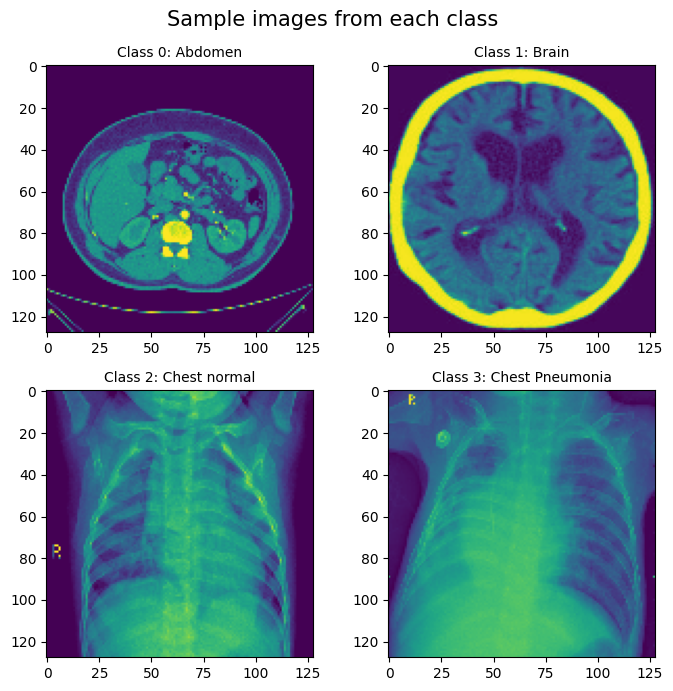

In [10]:
randomPlot(labels,resized_GS_images,class_names)

## Task B - Kernels, Gradients and Convolution 

Edge detection is a technique used in image processing to identify the boundaries between different objects in an image. It works by detecting sharp changes in brightness or color within an image. These changes are called edges and can be used to segment an image into different regions. Edge detection is often used as a preprocessing step for other computer vision tasks, such as object detection and image segmentation.

In [11]:
matrix = np.array([[0,0,0,0,0,0],[0,1,1,1,1,0],[0,1,1,1,1,0],[0,1,1,1,1,0],[0,1,1,1,1,0],[0,0,0,0,0,0]])

print("Matrix:")
print(matrix)

Matrix:
[[0 0 0 0 0 0]
 [0 1 1 1 1 0]
 [0 1 1 1 1 0]
 [0 1 1 1 1 0]
 [0 1 1 1 1 0]
 [0 0 0 0 0 0]]


Padding is a technique to increase the spatial dimensions of an input matrix by adding extra rows and columns of zeros around the edges of the input matrix.

Padding can prevents loss of information as after a convolution operations the output matrix is smaller than the original one. It can also help to prevent the edges of the input matrix from being ignored by convolution operations
We manually perform padding by adding a row and a column of zeros on all sides of the original matrix.

Look at the function called `manual_padding` that takes in a matrix as input and returns the padded matrix.

In [12]:
# Perform manual padding by adding a row and a column of zeros on all sides
def manual_padding(matrix):
    padded_matrix = np.zeros((matrix.shape[0] + 2, matrix.shape[1] + 2), dtype=matrix.dtype)
    padded_matrix[1:-1, 1:-1] = matrix
    return padded_matrix

- B1) Using the given 4x4 matrix of integers to do a zero padding. Padding is made by adding a row and a column on all sides of the original matrix. Write the padded matrix in the report.

In [13]:
padded_matrix = manual_padding(matrix)

print(padded_matrix)


[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


Pooling operations are used to reduce the spatial dimensions of an input matrix while retaining the most important features. The most common types of pooling operations are max pooling and average pooling.

Max pooling takes the maximum value within a window of a given size and moves the window across the input matrix. This reduces the spatial dimensions of the input matrix while retaining the most important features.

Average pooling takes the average value within a window of a given size and moves the window across the input matrix. This also reduces the spatial dimensions of the input matrix while retaining the most important features.

Pooling operations can help to reduce the number of features used by a model, which can help to prevent overfitting and improve generalization.

Check the `max_pooling` function.

In [14]:
def max_pooling(matrix):
    pool_size = 2
    pooled_matrix = np.zeros((matrix.shape[0] // pool_size + matrix.shape[0] % 2, matrix.shape[1] // pool_size + matrix.shape[1] % 2), dtype=matrix.dtype)
    for i in range(0, matrix.shape[0], pool_size):
        for j in range(0, matrix.shape[1], pool_size):
            window = matrix[i:i+pool_size, j:j+pool_size]
            max_value = np.max(window)
            pooled_matrix[i//pool_size, j//pool_size] = max_value
    return pooled_matrix


- B2) Using the padded matrix you obtained in the last step, perform max pooling with a 2x2 window using the given “max_pooling”. Write down the pooling matrix in the report.

In [15]:
max_pooled_matrix = max_pooling(padded_matrix)

print(max_pooled_matrix)

[[0 0 0 0]
 [0 1 1 0]
 [0 1 1 0]
 [0 0 0 0]]


The code is defining two Sobel kernels for horizontal and vertical edge detection. These kernels are used in image processing to detect edges in an image. The horizontal Sobel kernel is used to detect horizontal edges, while the vertical Sobel kernel is used to detect vertical edges. These kernels are applied to an image using convolution to highlight the edges in the image.

In [16]:
sobel_kernel_horizontal = np.array([[-1, 0, 1],
                                    [-2, 0, 2],
                                    [-1, 0, 1]])

sobel_kernel_vertical = np.array([[-1, -2, -1],
                                  [0, 0, 0],
                                  [1, 2, 1]])


The code defines a function called `convolution` that performs convolution between an input image and a given kernel.


In [17]:
def convolution(image, kernel):
    # Get the dimensions of the image and kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Create an output image with the same dimensions as the input image
    output_image = np.zeros_like(image)

    # Pad the input image to handle boundary pixels
    padding = kernel_width // 2
    padded_image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')

    # Perform convolution
    for i in range(image_height):
        for j in range(image_width):
            # Extract the region of interest (ROI) from the padded image
            roi = padded_image[i:i+kernel_height, j:j+kernel_width]
            
            # Compute the convolution result and store it in the output image
            output_image[i, j] = np.sum(roi * kernel)

    return np.array(output_image, dtype=np.float32)

- B3) Sobel filter is a commonly used filter in image processing. The purpose of using a sobel filter is to extract both the vertical and horizontal edges of the image. The fundamental operation of the sobel filter is convolution. Given both the vertical and horizontal Sobel kernel, Use the convolution function to apply the two kernels to detect the edges.    
“gradient_x” is the result of convolution of sobel horizontal kernel while “gradient_y” is the result of the sobel vertical kernel. 
- B4) Calculate the magnitude of the gradient and its orientation. NOTE: `np.arctan2()` returns a value in radians, convert it to degrees.

In [18]:
gradient_x = convolution(max_pooled_matrix,sobel_kernel_horizontal)
gradient_y = convolution(max_pooled_matrix,sobel_kernel_vertical)
abs_gradient = np.sqrt(gradient_x**2 + gradient_y**2)
angle_gradient = np.degrees(np.arctan2(gradient_y, gradient_x))

- B5) Plot the original matrix and the results obtained in the step before in a single plot (1x5 subfigures)
HINT: you can use any colormap for the gradients, for the angles plot use `cmap='twilight'` and plot the colorbar. Provide all figures in the report.

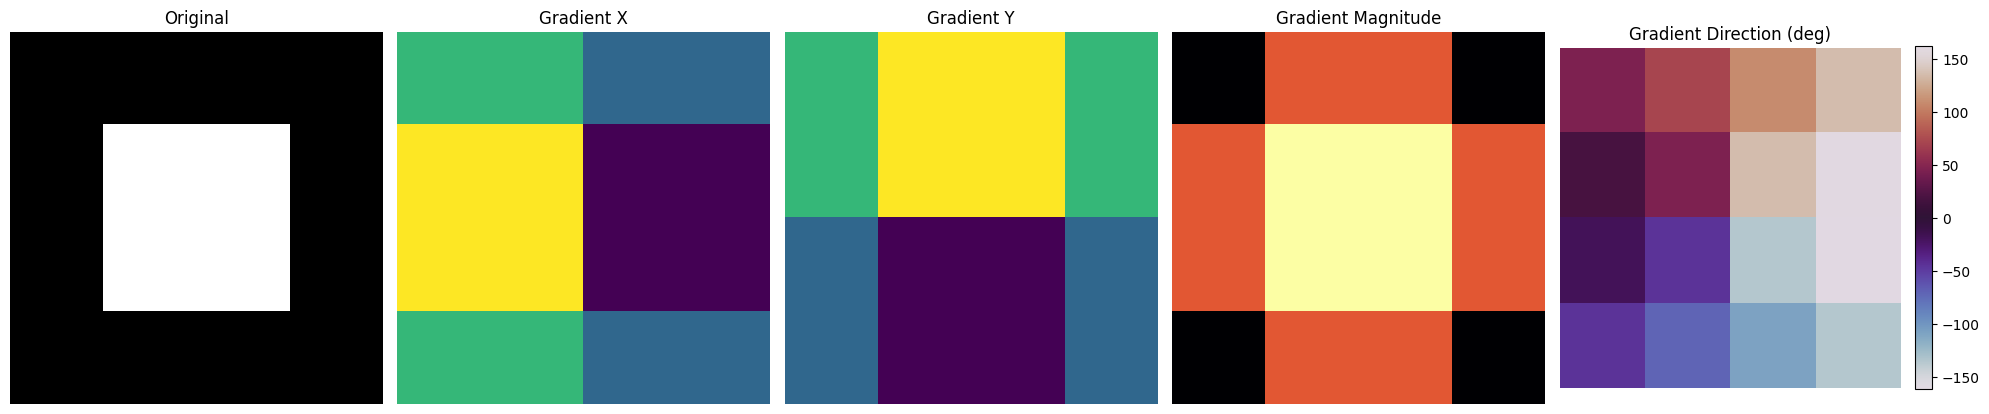

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# 1. Original matrix
axes[0].imshow(max_pooled_matrix, cmap='gray')
axes[0].set_title("Original")
axes[0].axis("off")

# 2. Gradient X
axes[1].imshow(gradient_x)
axes[1].set_title("Gradient X")
axes[1].axis("off")

# 3. Gradient Y
axes[2].imshow(gradient_y)
axes[2].set_title("Gradient Y")
axes[2].axis("off")

# 4. Gradient Magnitude
axes[3].imshow(abs_gradient, cmap='inferno')
axes[3].set_title("Gradient Magnitude")
axes[3].axis("off")

# 5. Gradient Direction (Angles in degrees)
im = axes[4].imshow(angle_gradient, cmap='twilight')
axes[4].set_title("Gradient Direction (deg)")
axes[4].axis("off")

plt.colorbar(im, ax=axes[4], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

Using the  `mpimg.imread()` function, load the "airplane.tiff" image file and:
- B7) compute the horizontal and vertical gradients
- B8) compute the the magnitude of the gradient and its orientation
- B9) perform max pooling on the image and repeat the previous steps (gradients, magnitudes, orientations). 

In [20]:
image = mpimg.imread("airplane.tiff")
grad_x = convolution(image,sobel_kernel_horizontal)
grad_y = convolution(image,sobel_kernel_vertical)
abs_grad = np.sqrt(grad_x**2 + grad_y**2)
angle_grad = np.degrees(np.arctan2(grad_y, grad_x))

pooled_image = max_pooling(image)
pooled_grad_x = convolution(image,sobel_kernel_horizontal)
pooled_grad_y = convolution(image,sobel_kernel_vertical)
abs_pooled_grad = np.sqrt(pooled_grad_x**2 + pooled_grad_y**2)
angle_pooled_grad = np.degrees(np.arctan2(pooled_grad_y, pooled_grad_x))

- B10) plot all the results in a single plot containing all the above results (2x5 subfigures) and put them in the report.

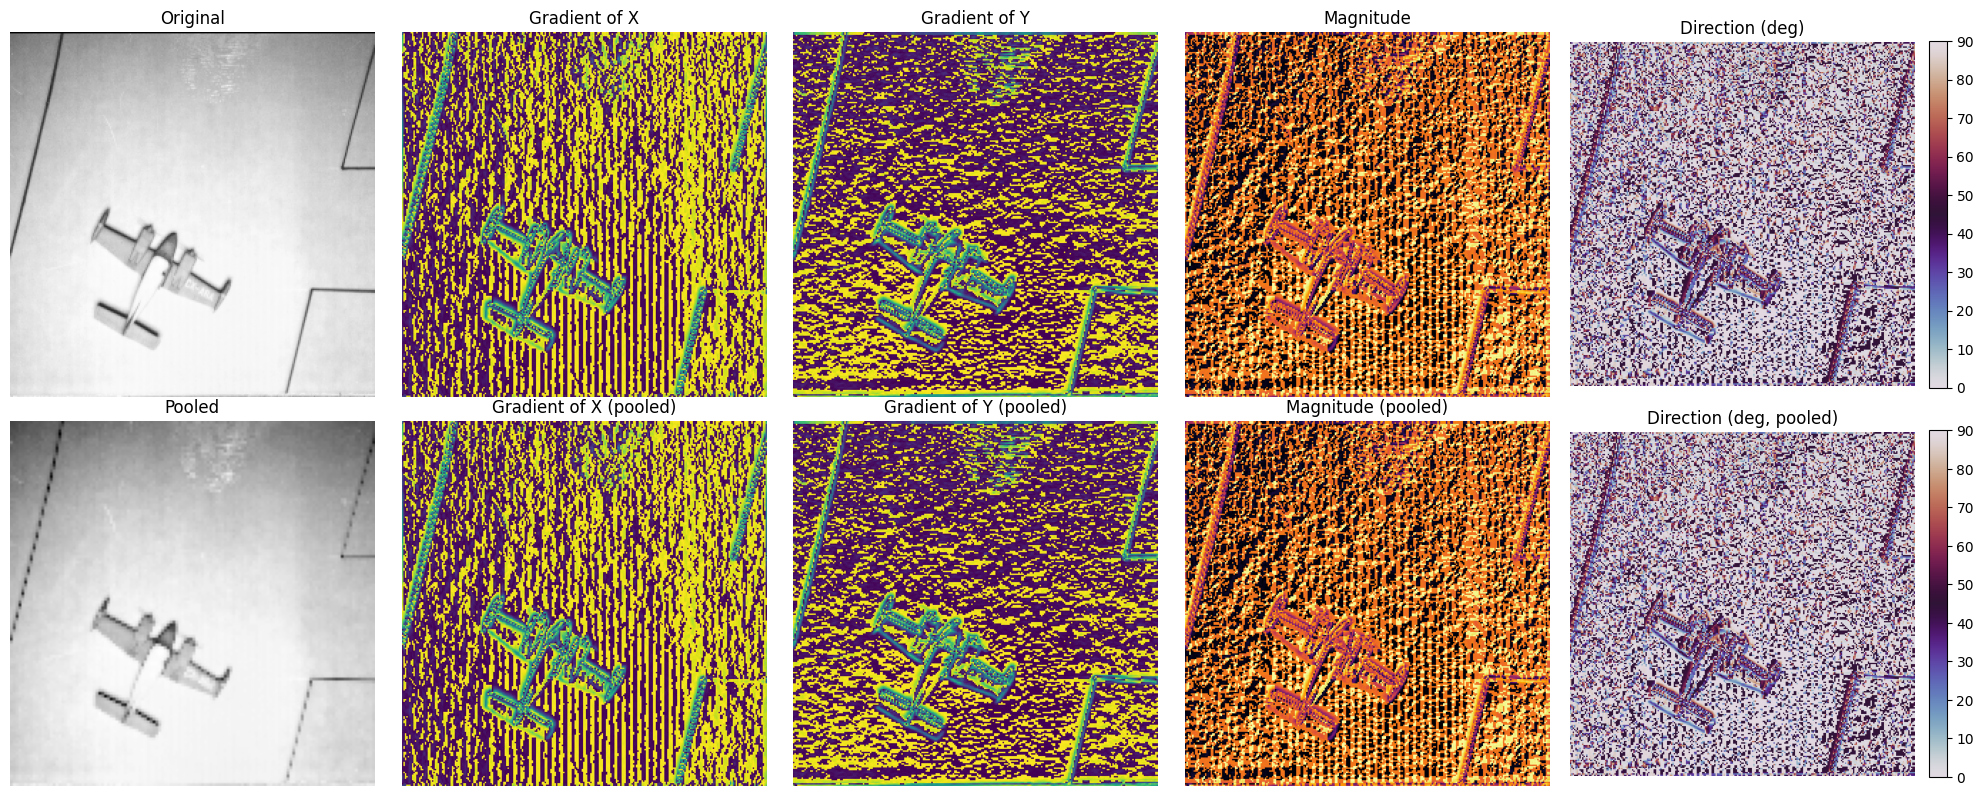

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# --- Original image results ---
axes[0,0].imshow(image, cmap="gray")
axes[0,0].set_title("Original")
axes[0,0].axis("off")

axes[0,1].imshow(grad_x)
axes[0,1].set_title("Gradient of X")
axes[0,1].axis("off")

axes[0,2].imshow(grad_y)
axes[0,2].set_title("Gradient of Y")
axes[0,2].axis("off")

axes[0,3].imshow(abs_grad, cmap="inferno")
axes[0,3].set_title("Magnitude")
axes[0,3].axis("off")

im1 = axes[0,4].imshow(angle_grad, cmap="twilight")
axes[0,4].set_title("Direction (deg)")
axes[0,4].axis("off")
plt.colorbar(im1, ax=axes[0,4], fraction=0.046, pad=0.04)

# --- Pooled image results ---
axes[1,0].imshow(pooled_image, cmap="gray")
axes[1,0].set_title("Pooled")
axes[1,0].axis("off")

axes[1,1].imshow(pooled_grad_x)
axes[1,1].set_title("Gradient of X (pooled)")
axes[1,1].axis("off")

axes[1,2].imshow(pooled_grad_y)
axes[1,2].set_title("Gradient of Y (pooled)")
axes[1,2].axis("off")

axes[1,3].imshow(abs_pooled_grad, cmap="inferno")
axes[1,3].set_title("Magnitude (pooled)")
axes[1,3].axis("off")

im2 = axes[1,4].imshow(angle_pooled_grad, cmap="twilight")
axes[1,4].set_title("Direction (deg, pooled)")
axes[1,4].axis("off")
plt.colorbar(im2, ax=axes[1,4], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

##### Questions
1. What is the difference between convolution with a kernel and pooling? Hint: Look at the size of the kernels and the resulting images.
2. Why two different kernels are used for horizontal and vertical edge detection? Could a single kernel be used for both?
3. What differences can you spot between the pooled and the original image? and in the resulting gradients?
4. Although the image is very simple and our brains can infer the edges of the object very simply, why are the resulting edges very noisy? What could be implemented to mitigate the noise?

## Task 3 - Feature Extraction: Histogram of Gradients and PCA 

In the context of feature extraction, HOG (Histogram of Oriented Gradients) and PCA (Principal Component Analysis) are two commonly used techniques.

Histogram of Oriented Gradients (HOG) is a feature extraction technique used to detect objects in images. It operates by dividing an image into small cells and then grouping the gradients in each cell according to a specified number of orientations. These grouped gradients, known as histograms, are concatenated to create a feature vector suitable for object detection. The HOG algorithm calculates gradient orientations in localized regions of an image, providing a comprehensive view of the image's gradient structure. To apply HOG, you can use the 'hog' function from the 'sklearn.feature' library, which allows you to extract both the HOG image and its corresponding HOG features. You can also print one of the processed images generated using the HOG technique.    
Hint: The `get_hog` function is a function that calculates the Histogram of Oriented Gradients (HOG) features and images for a given set of images.

In [22]:
from skimage.feature import hog

def get_hog(image_set, size_1, orientations=8):
    hog_images = []
    hog_features = []
    for image in image_set:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(size_1, size_1), cells_per_block=(4,4), visualize=True)
        hog_images.append(hog_image)
        hog_features.append(fd)

    return np.array(hog_features), np.array(hog_images,dtype=np.float32)

- C1) Extract the HOG feature from the dataset, using `size_1=[16,32]` and `orientations=[4, 8]`. 
    >NOTE: computing the HOG features can take up to three minutes.

In [23]:
hog_features_16_4, hog_images_16_4 = get_hog(resized_GS_images,16,4)
hog_features_16_8, hog_images_16_8 = get_hog(resized_GS_images,16,8)
hog_features_32_4, hog_images_32_4 = get_hog(resized_GS_images,32,4)
hog_features_32_8, hog_images_32_8 = get_hog(resized_GS_images,32,8)

- C2) Plot the 250th image of each variant of HOG images, and the shapes of the respective feature vectors. Provide them in the report and write down your observations.

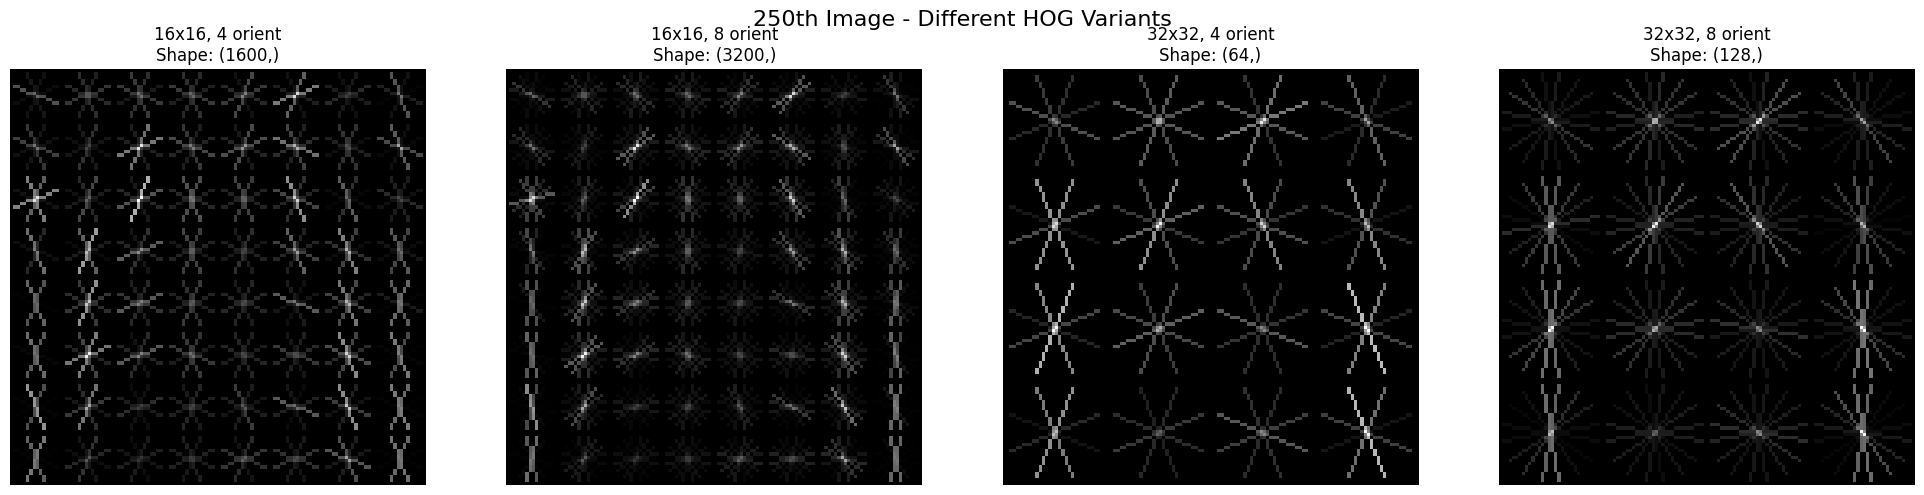

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("250th Image - Different HOG Variants", fontsize=16)

# --- Variant 1: 16x16, 4 orientations
axes[0].imshow(hog_images_16_4[249], cmap="gray")
axes[0].set_title(f"16x16, 4 orient\nShape: {hog_features_16_4[249].shape}")
axes[0].axis("off")

# --- Variant 2: 16x16, 8 orientations
axes[1].imshow(hog_images_16_8[249], cmap="gray")
axes[1].set_title(f"16x16, 8 orient\nShape: {hog_features_16_8[249].shape}")
axes[1].axis("off")

# --- Variant 3: 32x32, 4 orientations
axes[2].imshow(hog_images_32_4[249], cmap="gray")
axes[2].set_title(f"32x32, 4 orient\nShape: {hog_features_32_4[249].shape}")
axes[2].axis("off")

# --- Variant 4: 32x32, 8 orientations
axes[3].imshow(hog_images_32_8[249], cmap="gray")
axes[3].set_title(f"32x32, 8 orient\nShape: {hog_features_32_8[249].shape}")
axes[3].axis("off")

plt.tight_layout()
plt.show()

Principal Component Analysis (PCA) is a fundamental method in machine learning used for constructing features and dimensionality reduction. In this section, you will utilize the PCA function from 'sklearn.decomposition' to extract features from the provided dataset. PCA identifies the principal components of a dataset, which represent the directions in which the data exhibits the most variation. By projecting a feature vector onto a lower-dimensional subspace defined by these principal components, PCA effectively reduces the dimensionality of the data while retaining the essential information capturing the primary data variations.

- C3) Apply `PCA` to the resized dataset. Hint: `PCA` works in one dimension only, so reshape the images accordingly.
- C4) Plot (scatter) the first two components of the PCA transformed features in the report.

(400, 128, 128)


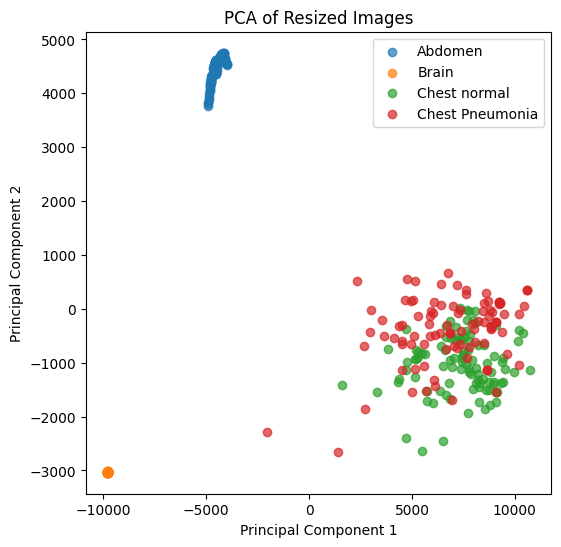

In [38]:
from sklearn.decomposition import PCA
print(resized_GS_images.shape)
n, h, w = resized_GS_images.shape
x_flattened = resized_GS_images.reshape(n,h*w)

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_flattened)

# Plot the first two principal components of each point

plt.figure(figsize=(6,6))
for c in np.unique(labels):
    idx = np.where(labels == c)
    plt.scatter(x_pca[idx,0], x_pca[idx,1], alpha=0.7, label=class_names[c])

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Resized Images")
plt.legend()
plt.show()

- C5) Plot the explained variance ratio and cumulative explained variance ratio of the first 20 components in the report.

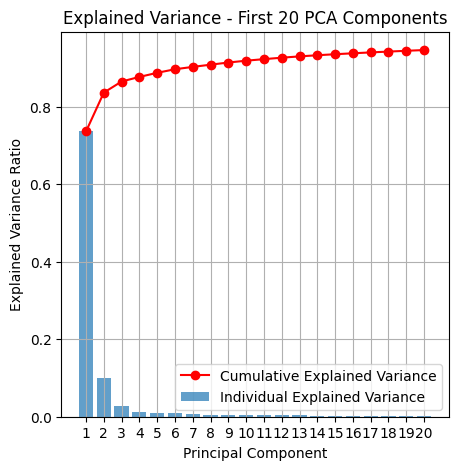

In [26]:
n_comp = 20
pca2 = PCA(n_components=n_comp)
x_pca2 = pca2.fit_transform(x_flattened)

explained_var = pca2.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(5,5))
components = np.arange(1, n_comp+1)

plt.bar(components, explained_var, alpha=0.7, label='Individual Explained Variance')
plt.plot(components, cumulative_var, color='red', marker='o', label='Cumulative Explained Variance')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance - First 20 PCA Components")
plt.xticks(components)
plt.legend()
plt.grid(True)
plt.show()

#### Questions:
1. What can you notice between the HOG images extracted using 16 or 32 pixels/cell? Relate to feature vector(s) sizes and compare it with the original flattened images.
2. How does the model performance vary between generated HOG images?
3. In the PCA plot, what do you observe in the two-component plot?
4. Can you relate the description of Classes 2 and 3 in the dataset, with the behavior highlighted by the previous question?
5. What does the explained variance of each component represent?

## Task D - Model Training 

In this task, you will classify images and the related extracted features. We will define a function “Classifier” that fits the classification model, compute Accuracy, Recall, Precision, F1, and AUC and plot the confusion matrix.


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,f1_score, precision_score, roc_auc_score, recall_score, confusion_matrix
import seaborn as sns

The code defines a function called `Classifier` that takes in several parameters: `clf` (a classifier object), `x_train` (the training data features), `y_train` (the training data labels), `x_test` (the test data features), and `y_test` (the test data labels).

- D1) Complete the `Classifier` function so that:
    - The input model is fitted to the given data, and predictions are made on the test data.
    - The following metrics are computed with respect to the test data and printed:
        - Accuracy
        - Precision
        - Recall
        - F1 Score.
    >Note: for these last 3 metrics, when computing include the argument `average='macro'`.
    - The confusion matrix is plotted and displayed.

In [28]:
def Classifier(clf,x_train,y_train,x_test,y_test):

    #fit the model
    clf.fit(x_train, y_train)

    #predict on the test set
    y_pred = clf.predict(x_test)

    # print the scores
    Accuracy_clf = accuracy_score(y_test,y_pred)
    F1_clf = f1_score(y_test,y_pred, average='macro')
    Precision_clf = precision_score(y_test,y_pred, average='macro')
    Recall_clf = recall_score(y_test,y_pred, average='macro')
    print("Accuracy: " + str(Accuracy_clf))
    print("F1 score: " + str(F1_clf))
    print("Recall score: " + str(Precision_clf))
    print("Precision score: " + str(Recall_clf))

    # plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

From now on, when creating train/test splits, use `test_size=0.2, random_state=42`

- D2) train the following models on the flattened image data. Put the output of “Classifier” and your observations for each model in the report. (Hint: 9 model output)
    - k-NN, using as `n_neighbors=[3,4,5]`
    - SVM, changing between `kernels=['linear','poly','rbf']`, when using poly use degree=3.  
    For all kernels use `[gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3]`. 
    - MLP, changing the `hidden_layer_sizes=[(100),(100,100),(100,100,100)]`.  
    For the remaining parameters always use `[activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42]`

KNN
k-value 3
Accuracy: 0.9375
F1 score: 0.9300699300699301
Recall score: 0.9357142857142857
Precision score: 0.9305555555555556
k-value 4
Accuracy: 0.95
F1 score: 0.9442724458204335
Recall score: 0.946875
Precision score: 0.9444444444444444
k-value 5
Accuracy: 0.9375
F1 score: 0.9300699300699301
Recall score: 0.9357142857142857
Precision score: 0.9305555555555556
SVC
kernel linear
Accuracy: 0.9625
F1 score: 0.9583011583011583
Recall score: 0.9589783281733746
Precision score: 0.9583333333333334
kernel poly
Accuracy: 0.95
F1 score: 0.9442724458204335
Recall score: 0.946875
Precision score: 0.9444444444444444
kernel rbf


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.5125
F1 score: 0.478695652173913
Recall score: 0.5789473684210527
Precision score: 0.5694444444444444
MLP
layers (100,)
Accuracy: 0.925
F1 score: 0.9166882137470372
Recall score: 0.9211309523809523
Precision score: 0.9166666666666667
layers (100, 100)
Accuracy: 0.9
F1 score: 0.8889705882352942
Recall score: 0.8963068181818181
Precision score: 0.8888888888888888
layers (100, 100, 100)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7125
F1 score: 0.6052036199095023
Recall score: 0.5584415584415585
Precision score: 0.6805555555555556


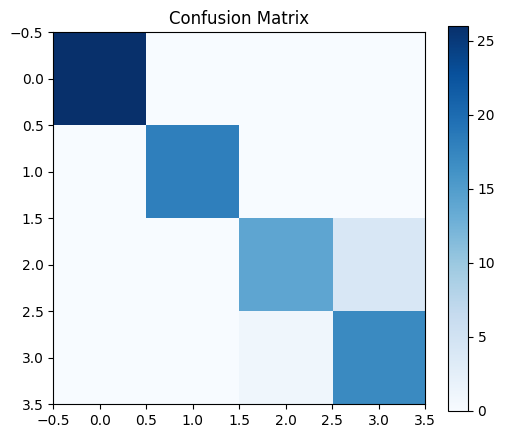

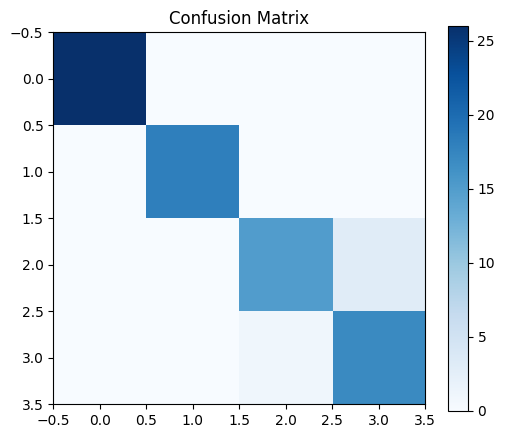

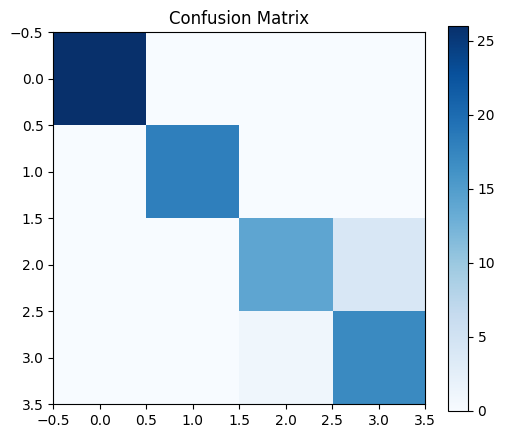

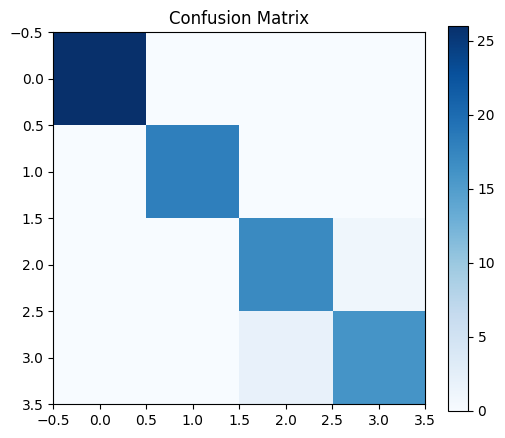

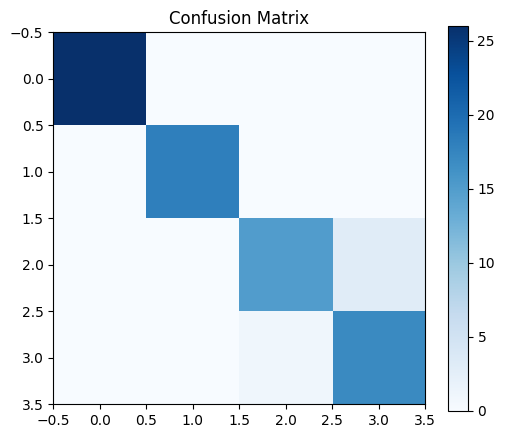

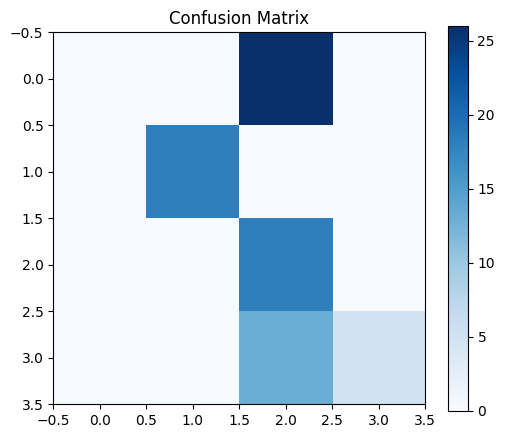

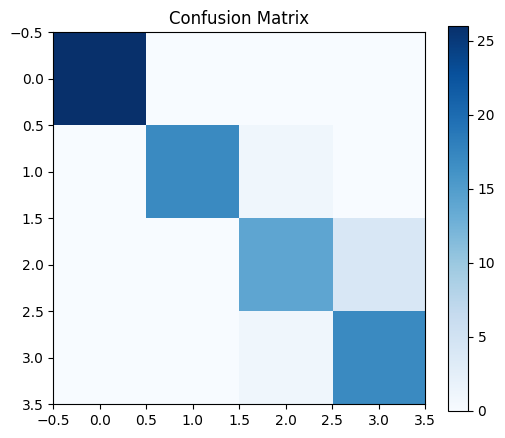

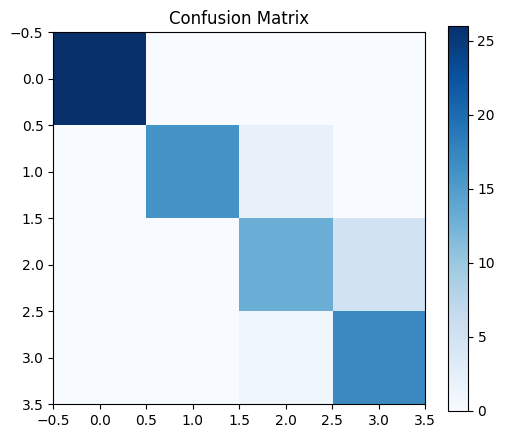

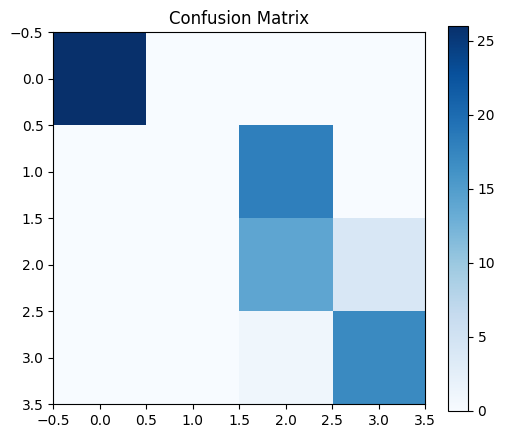

In [34]:
X_train, X_test, y_train, y_test = train_test_split(x_flattened,labels,test_size=0.2,random_state=42)

### knn
print("KNN")
for k in [3, 4, 5]:
    print("k-value",k)
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    Classifier(clf_knn,X_train,y_train,X_test,y_test)

### svc
print("SVC")
for kernel in ['linear','poly','rbf']:
    print("kernel",kernel)
    if kernel == 'poly':
        clf_svc = SVC(kernel=kernel, degree=3, gamma='auto', C=1.0, coef0=0.0, tol=1e-3, random_state=42)
    else:
        clf_svc = SVC(kernel=kernel, gamma='auto', C=1.0, coef0=0.0, tol=1e-3, random_state=42)
    Classifier(clf_svc,X_train,y_train,X_test,y_test)

### mlp
print("MLP")
for layers in [(100,), (100,100), (100,100,100)]:
    print("layers",layers)
    clf_mlp = MLPClassifier(hidden_layer_sizes=layers,
                            activation='relu',
                            solver='adam',
                            alpha=0.0001,
                            max_iter=200,
                            shuffle=True,
                            random_state=42)
    Classifier(clf_mlp,X_train,y_train,X_test,y_test)

- D3) Using the 4 sets of HOG features obtained before, repeat the training process on new classifier instances. Put the output of “Classifier” and your observations for each model in the report:
    - kNN, with `neighbors=4`
    - SVC, with  `kernel='linear'`  
    Again use `[gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3]`. 
    - MLP, with `hidden_layer_size=(100)`  
    For the remaining parameters always use `[activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42]`

KNN
Accuracy: 0.9625
F1 score: 0.9580419580419581
Recall score: 0.9642857142857143
Precision score: 0.9583333333333334
Accuracy: 0.975
F1 score: 0.9721362229102166
Recall score: 0.975
Precision score: 0.9722222222222222
Accuracy: 0.975
F1 score: 0.9721362229102166
Recall score: 0.975
Precision score: 0.9722222222222222
Accuracy: 0.9625
F1 score: 0.9583011583011583
Recall score: 0.9589783281733746
Precision score: 0.9583333333333334
SVC
Accuracy: 0.975
F1 score: 0.9722222222222223
Recall score: 0.9722222222222223
Precision score: 0.9722222222222223
Accuracy: 0.95
F1 score: 0.9442724458204335
Recall score: 0.946875
Precision score: 0.9444444444444444
Accuracy: 0.975
F1 score: 0.9721362229102166
Recall score: 0.975
Precision score: 0.9722222222222222
Accuracy: 0.975
F1 score: 0.9721362229102166
Recall score: 0.975
Precision score: 0.9722222222222222
MLP


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.975
F1 score: 0.9721362229102167
Recall score: 0.975
Precision score: 0.9722222222222222
Accuracy: 0.975
F1 score: 0.9721362229102167
Recall score: 0.975
Precision score: 0.9722222222222222


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.95
F1 score: 0.9442724458204335
Recall score: 0.946875
Precision score: 0.9444444444444444


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9375
F1 score: 0.9300699300699301
Recall score: 0.9357142857142857
Precision score: 0.9305555555555556


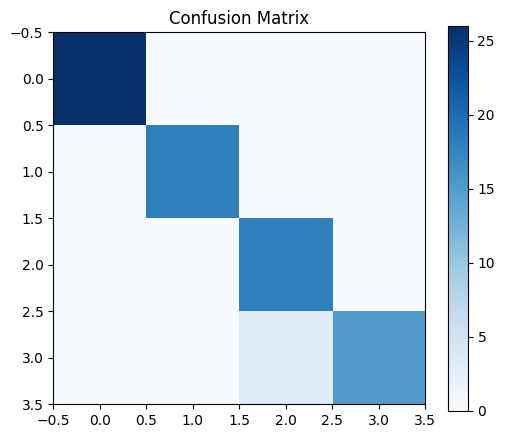

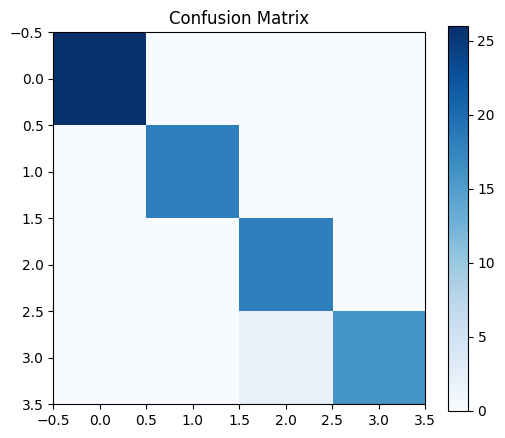

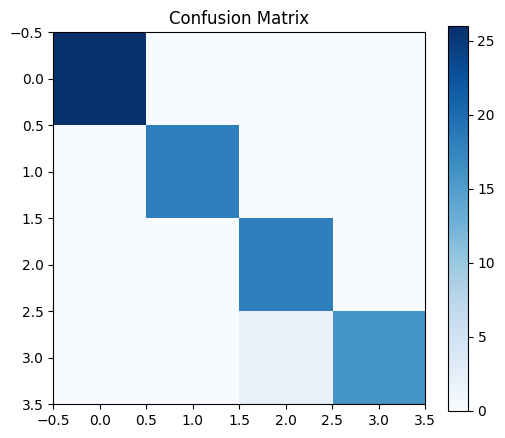

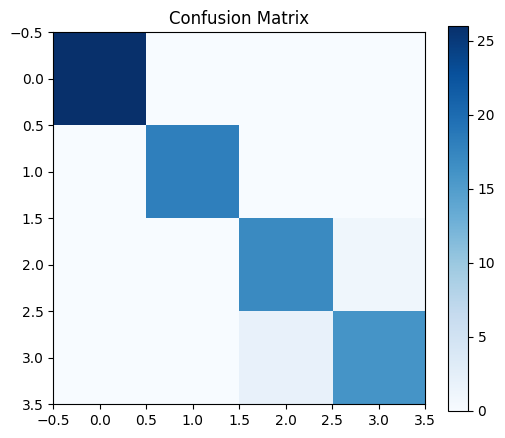

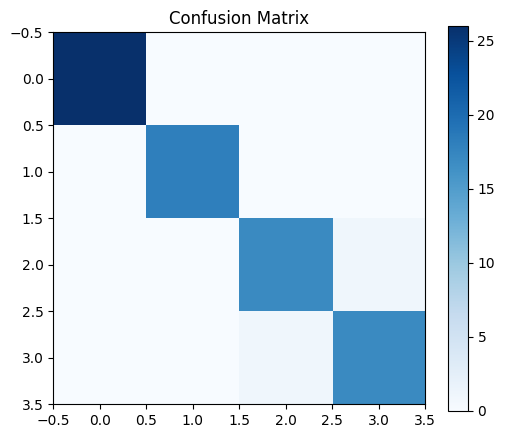

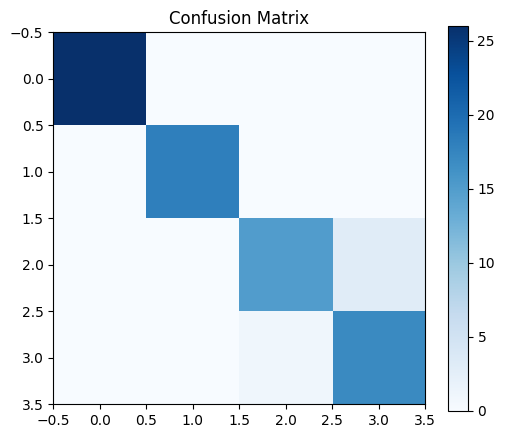

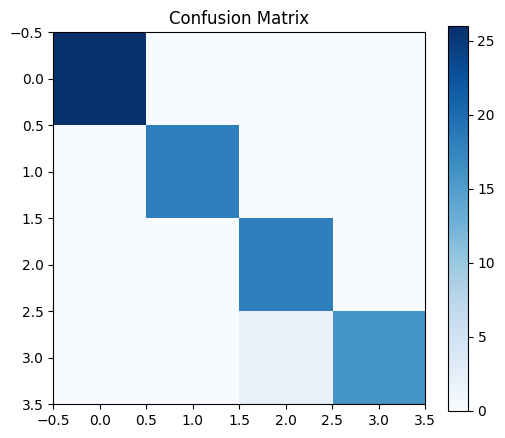

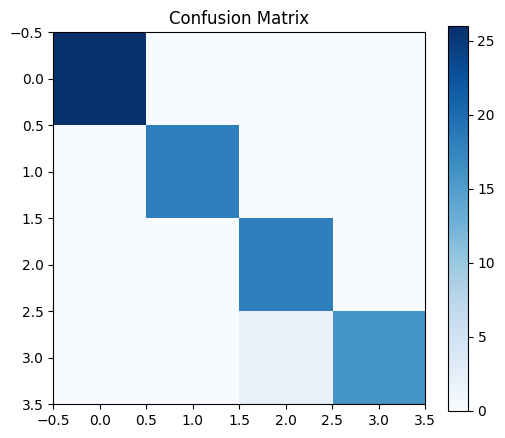

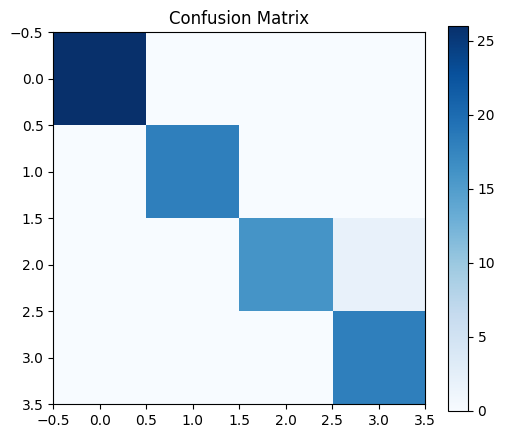

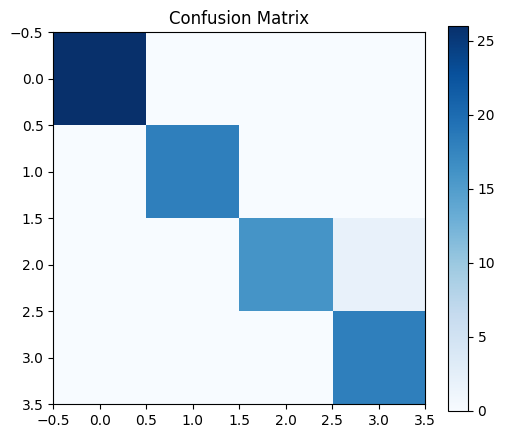

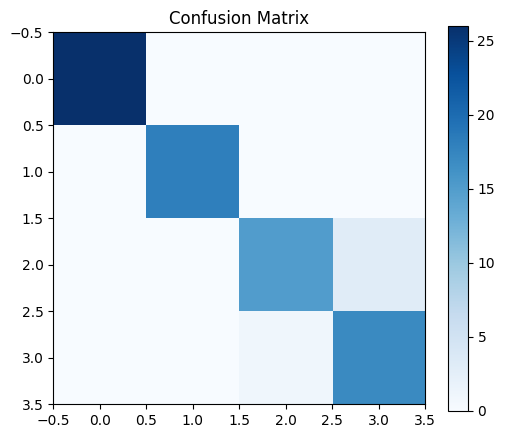

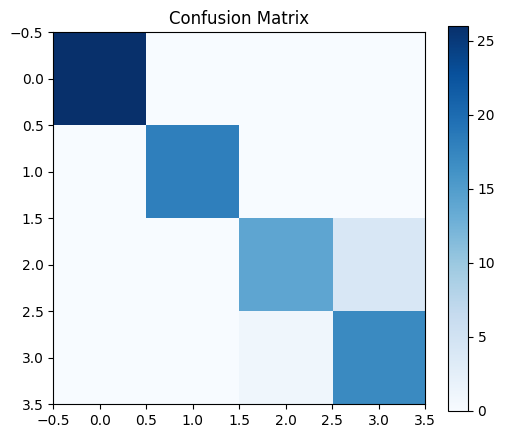

In [30]:
x_train_hog_16_4, x_test_hog_16_4, y_train_hog_16_4, y_test_hog_16_4 = train_test_split(hog_features_16_4, labels, test_size=0.2, random_state=42)
x_train_hog_16_8, x_test_hog_16_8, y_train_hog_16_8, y_test_hog_16_8 = train_test_split(hog_features_16_8, labels, test_size=0.2, random_state=42)
x_train_hog_32_4, x_test_hog_32_4, y_train_hog_32_4, y_test_hog_32_4 = train_test_split(hog_features_32_4, labels, test_size=0.2, random_state=42)
x_train_hog_32_8, x_test_hog_32_8, y_train_hog_32_8, y_test_hog_32_8 = train_test_split(hog_features_32_8, labels, test_size=0.2, random_state=42)

print("KNN")
knn_hog_16_4 = KNeighborsClassifier(n_neighbors=4)
Classifier(knn_hog_16_4,x_train_hog_16_4,y_train_hog_16_4,x_test_hog_16_4,y_test_hog_16_4)
knn_hog_16_8 = KNeighborsClassifier(n_neighbors=4)
Classifier(knn_hog_16_8,x_train_hog_16_8,y_train_hog_16_8,x_test_hog_16_8,y_test_hog_16_8)
knn_hog_32_4 = KNeighborsClassifier(n_neighbors=4)
Classifier(knn_hog_32_4,x_train_hog_32_4,y_train_hog_32_4,x_test_hog_32_4,y_test_hog_32_4)
knn_hog_32_8 = KNeighborsClassifier(n_neighbors=4)
Classifier(knn_hog_32_8,x_train_hog_32_8,y_train_hog_32_8,x_test_hog_32_8,y_test_hog_32_8)
### svc
print("SVC")
clf_svc_16_4 = SVC(kernel='linear', gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3)
Classifier(clf_svc_16_4,x_train_hog_16_4,y_train_hog_16_4,x_test_hog_16_4,y_test_hog_16_4)
clf_svc_16_8 = SVC(kernel='linear', gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3)
Classifier(clf_svc_16_8,x_train_hog_16_8,y_train_hog_16_8,x_test_hog_16_8,y_test_hog_16_8)
clf_svc_32_4 = SVC(kernel='linear', gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3)
Classifier(clf_svc_32_4,x_train_hog_32_4,y_train_hog_32_4,x_test_hog_32_4,y_test_hog_32_4)
clf_svc_32_8 = SVC(kernel='linear', gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3)
Classifier(clf_svc_32_8,x_train_hog_32_8,y_train_hog_32_8,x_test_hog_32_8,y_test_hog_32_8)
### mlp 
print("MLP")
clf_mlp_16_4 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                             alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(clf_mlp_16_4,x_train_hog_16_4,y_train_hog_16_4,x_test_hog_16_4,y_test_hog_16_4)
clf_mlp_16_8 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                             alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(clf_mlp_16_8,x_train_hog_16_8,y_train_hog_16_8,x_test_hog_16_8,y_test_hog_16_8)
clf_mlp_32_4 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                             alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(clf_mlp_32_4,x_train_hog_32_4,y_train_hog_32_4,x_test_hog_32_4,y_test_hog_32_4)
clf_mlp_32_8 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                             alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(clf_mlp_32_8,x_train_hog_32_8,y_train_hog_32_8,x_test_hog_32_8,y_test_hog_32_8)



- D4) Now repeat the training step using the PCA features, using:
    - kNN, with `neighbors=4`
    - SVC, with  `kernel='linear'`
    - MLP, with `hidden_layer_size=(100)`  
    again use for the remaining parameters always use `[activation='relu', solver='adam', alpha=0.0001, max_iter=200, shuffle=True, random_state=42]`

>Train all models first using only the first two PCA components, then the first 10, then all.

KNN
Accuracy: 0.95
F1 score: 0.9442724458204335
Recall score: 0.946875
Precision score: 0.9444444444444444
Accuracy: 0.9625
F1 score: 0.9583011583011583
Recall score: 0.9589783281733747
Precision score: 0.9583333333333333
Accuracy: 0.8625
F1 score: 0.8442171518489378
Recall score: 0.8553511705685619
Precision score: 0.8472222222222223
SVC
Accuracy: 0.95
F1 score: 0.9442724458204335
Recall score: 0.946875
Precision score: 0.9444444444444444
Accuracy: 0.9375
F1 score: 0.9305019305019305
Recall score: 0.9311145510835913
Precision score: 0.9305555555555556
Accuracy: 0.85
F1 score: 0.8285714285714286
Recall score: 0.84375
Precision score: 0.8333333333333334
MLP
Accuracy: 0.8125
F1 score: 0.8035975649921838
Recall score: 0.8081521739130435
Precision score: 0.813034188034188
Accuracy: 0.9375
F1 score: 0.9305019305019305
Recall score: 0.9311145510835913
Precision score: 0.9305555555555556
Accuracy: 0.85
F1 score: 0.83125
Recall score: 0.8376623376623377
Precision score: 0.8333333333333333


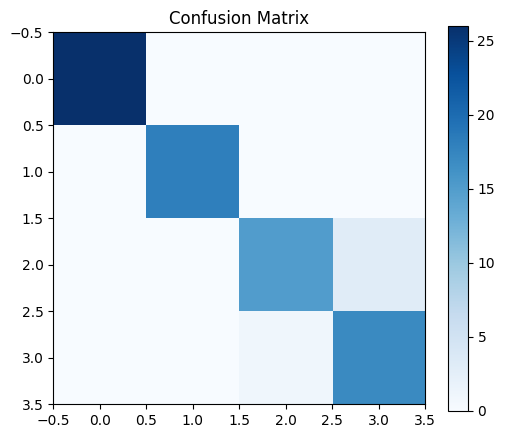

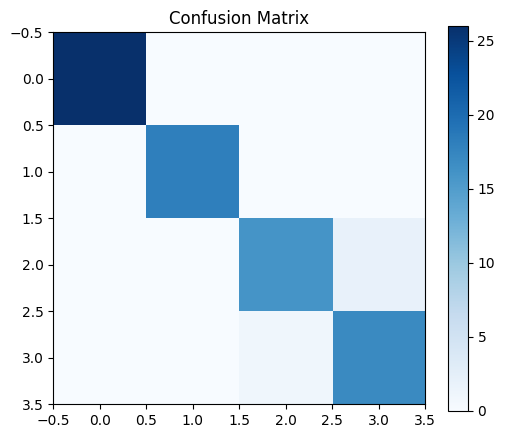

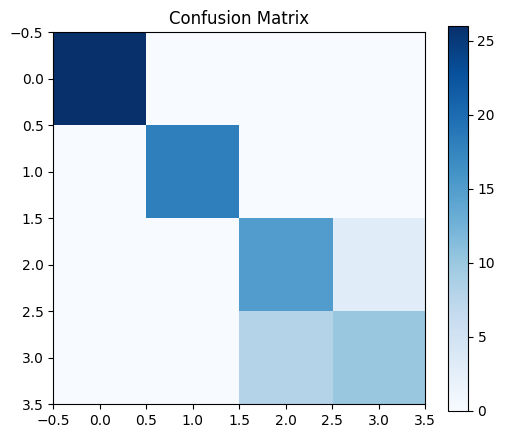

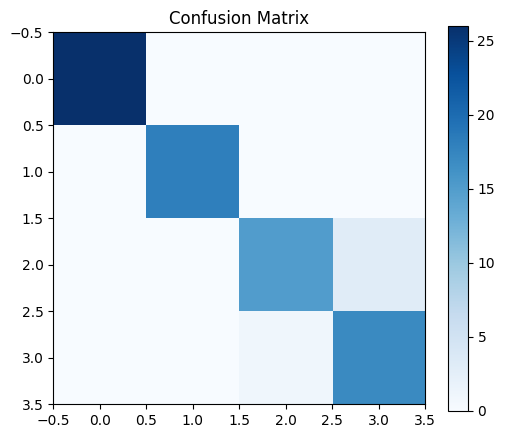

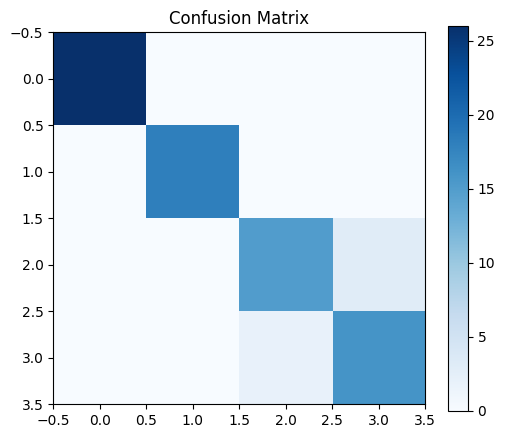

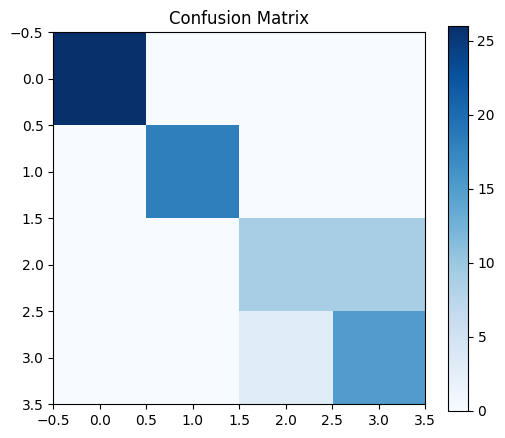

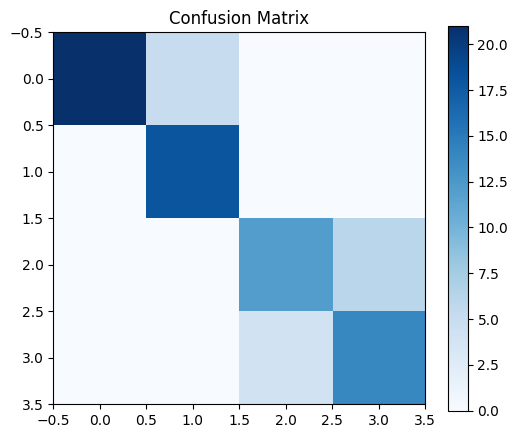

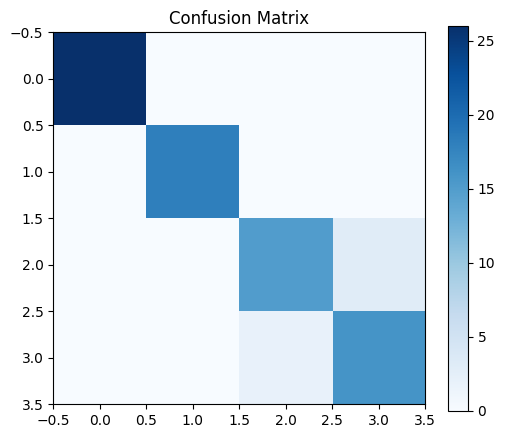

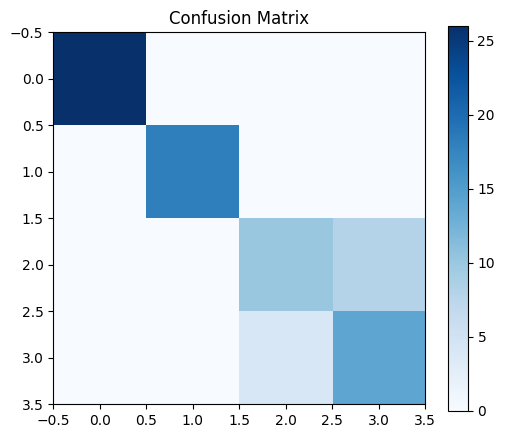

In [33]:
n, h, w = resized_GS_images.shape
x_flattened = resized_GS_images.reshape(n,h*w)
pca = PCA()
x_pca_all = pca.fit_transform(x_flattened)
x_pca_10 = x_pca_all[:,:10]
x_pca_2 = x_pca_all[:,:2]

X_train_pca_all, X_test_pca_all, y_train_pca_all, y_test_pca_all = train_test_split(x_pca_all, labels, test_size=0.2, random_state=42)
X_train_pca_10, X_test_pca_10, y_train_pca_10, y_test_pca_10 = train_test_split(x_pca_10, labels, test_size=0.2, random_state=42)
X_train_pca_2, X_test_pca_2, y_train_pca_2, y_test_pca_2 = train_test_split(x_pca_2, labels, test_size=0.2, random_state=42)

print("KNN")
knn_pca_all = KNeighborsClassifier(n_neighbors=4)
Classifier(knn_pca_all,X_train_pca_all,y_train_pca_all,X_test_pca_all,y_test_pca_all)
knn_pca_10 = KNeighborsClassifier(n_neighbors=4)
Classifier(knn_pca_10,X_train_pca_10,y_train_pca_10,X_test_pca_10,y_test_pca_10)
knn_pca_2 = KNeighborsClassifier(n_neighbors=4)
Classifier(knn_pca_2,X_train_pca_2,y_train_pca_2,X_test_pca_2,y_test_pca_2)

### svc
print("SVC")
clf_svc_pca_all = SVC(kernel='linear', gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3)
Classifier(knn_pca_all,X_train_pca_all,y_train_pca_all,X_test_pca_all,y_test_pca_all)
clf_svc_pca_10 = SVC(kernel='linear', gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3)
Classifier(clf_svc_pca_10,X_train_pca_10,y_train_pca_10,X_test_pca_10,y_test_pca_10)
clf_svc_pca_2 = SVC(kernel='linear', gamma='auto', random_state=42, C=1.0, coef0=0.0, tol=1e-3)
Classifier(clf_svc_pca_2,X_train_pca_2,y_train_pca_2,X_test_pca_2,y_test_pca_2)

### mlp 
print("MLP")
clf_mlp_pca_all = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                             alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(clf_mlp_pca_all,X_train_pca_all,y_train_pca_all,X_test_pca_all,y_test_pca_all)
clf_mlp_pca_10 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                             alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(clf_mlp_pca_10,X_train_pca_10,y_train_pca_10,X_test_pca_10,y_test_pca_10)
clf_mlp_pca_2 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                             alpha=0.0001, max_iter=200, shuffle=True, random_state=42)
Classifier(clf_mlp_pca_2,X_train_pca_2,y_train_pca_2,X_test_pca_2,y_test_pca_2)

Questions:
1. What is the best performing model trained on the flattened images? Why?
2. What is the best performing model using the HOG features? With which HOG set? Why?
3. What is the best performing model using PCA features? With how many components? Why?
4. Regarding the models trained with PCA features, analyze the SVC performance.
5. For the SVC with PCA features, try the RBF and poly kernels in a new cell, using the three variations of the PCA sets. Compare performances of these kernels? (Iteration limits might be required for poly kernels)
6. Based on the confusion matrices, can you spot a recurring pattern in the classification results? Relate this pattern with the component plot in task 3 and the original dataset.
7. Explain why higher number of layers does not translate in better accuracy HOG features?


## Bonus - Pneumonia Classification & Grid Search 
For this bonus task you will have to discard the samples belonging to classes 0 and 1, and assign the 0 and 1 values to classes 2 and 3. Then you will train a KNN classifier, a SVC and an MLP classifier using the grid search algorithm to identify the best hyperparameters for the new task.    
Use the following parameter grids:    
−	knn_param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}    
−	svm_param_grid = {'kernel': ['linear', 'rbf','poly'], 'C': [0.1, 1, 10], 'max_iter':[300]}    
−	mlp_param_grid = {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 'alpha': [0.0001, 0.001, 0.01], 'max_iter':[300]}    
Use the identified parameters for the following tasks.    
•	Train with normal flattened images    
•	Train with HOG    
•	Train with PCA    
Compare and analyze the best-performing hyperparameter set for each model and training data. Identify the most suitable model and corresponding feature set for this CodeLab. Can you propose another feature engineering method to improve the model performance? Explain. 